In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # This function transforms the image into a tensor, and normalizes it to (0.5 * 3,) mean and the same std.

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_load = torch.utils.data.DataLoader(train_set, batch_size = 4, shuffle = True, num_workers = 2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_load = torch.utils.data.DataLoader(test_set, batch_size = 1000, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataiter = enumerate(test_load)
idx, (data, truth) = next(dataiter)

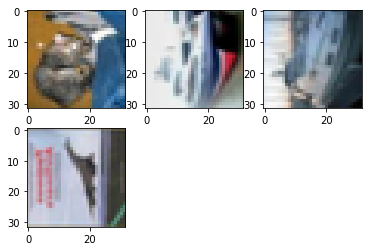

In [4]:
fig = plt.figure()
for i in range(0,4):
    img = torchvision.utils.make_grid(data[i])
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.subplot(2,3, i+1)
    plt.imshow(np.transpose(npimg)) 
plt.show()

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, 2)
        self.conv2 = nn.Conv2d(50, 40, 2)
        self.conv3 = nn.Conv2d(40, 30, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(3) # 1st normalization of data through 3 channels.
        self.bn2 = nn.BatchNorm2d(50) # 2nd normalization of data through 50 channels.
        self.bn3 = nn.BatchNorm2d(40) # 3rd normalization of data through 40 channels.
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(30*6*6, 120)
        self.fc2 = nn.Linear(120, 90)
        self.fc3 = nn.Linear(90, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(x) # Data is normalized before each convolution pool.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn3(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 30*6*6)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # Dropout to prevent overfitting.
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
net = Net()

In [7]:
criterion = nn.CrossEntropyLoss() # Uses cross entropy loss.
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9) # Stochastic GD

In [8]:
for epochs in range(1):  # loop over the dataset multiple times
    training_loss = 0
    for batch_idx, (inputs, labels) in enumerate(train_load, 0):
        optimizer.zero_grad() # Zero the parameter gradients.
        outputs = net(inputs) # Runs the training batch through the network.
        loss = criterion(outputs, labels) # Calculates the loss.
        loss.backward() # Backpropagation.
        optimizer.step() # Updates gradients.
        training_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epochs + 1, batch_idx + 1, training_loss / 2000))
            training_loss = 0 # Resets every 2000 batches.
print('Finished Training.')

[1,  2000] loss: 2.233
[1,  4000] loss: 1.916
[1,  6000] loss: 1.712
[1,  8000] loss: 1.590
[1, 10000] loss: 1.505
[1, 12000] loss: 1.457
Finished Training.


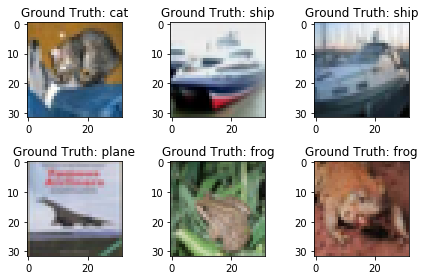

In [9]:
dataiter = enumerate(test_load)
index, (images, labels) = next(dataiter)
fig = plt.figure()
for i in range(0,6):
    img = torchvision.utils.make_grid(images[i])
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.subplot(2,3, i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(npimg,(1,2,0))) 
    plt.title("Ground Truth: {}".format(classes[labels[i]]))
plt.show()

In [11]:
correct = 0
total = 0
with torch.no_grad(): # Sets all data to not require a gradient.
    for images, labels in test_load:
        outputs = net(images) # Testing on the neural network with the testing set.
        _, predicted = torch.max(outputs.data, 1) # Receives the predictions by taking the option with the max predicted probability.
        total += labels.size(0) # Sum total.
        correct += (predicted == labels).sum().item() # Counts all the correct predicted images from the test set.

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


In [ ]:
confusion_matrix = np.zeros([10,10], int)
for images, labels in test_load:
    for i, j in enumerate(labels): # i is the index of the predicted, and j is the index of the specific class.
        confusion_matrix[j.item(), predicted[i].item()] += 1 # Counts for each case.

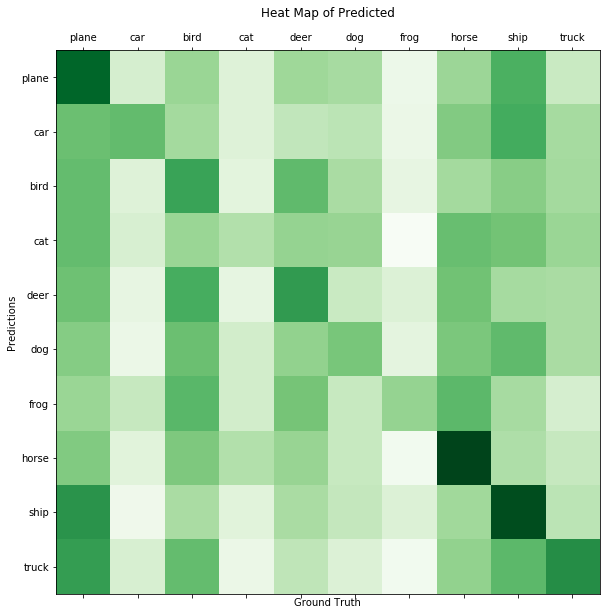

In [29]:
# Heat Map of Predicted Labels.

fig, matrix = plt.subplots(1,1,figsize=(10,10))
matrix.matshow(confusion_matrix, aspect='equal', cmap=plt.get_cmap('Greens'))
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.xticks(range(10),classes)
plt.yticks(range(10),classes)
plt.title('Heat Map of Predicted')
plt.show()